In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/793 [..............................] - ETA: 15:50 - loss: 0.2061 - STD: 1.3482e-04 - MAE: 0.4431

 10/793 [..............................] - ETA: 4s - loss: 0.0440 - STD: 2.4235e-04 - MAE: 0.1619   

 19/793 [..............................] - ETA: 4s - loss: 0.0371 - STD: 1.3484e-04 - MAE: 0.1527

 28/793 [>.............................] - ETA: 4s - loss: 0.0296 - STD: 1.0332e-04 - MAE: 0.1319

 37/793 [>.............................] - ETA: 4s - loss: 0.0252 - STD: 8.7729e-05 - MAE: 0.1218

 45/793 [>.............................] - ETA: 4s - loss: 0.0224 - STD: 7.5035e-05 - MAE: 0.1132

 53/793 [=>............................] - ETA: 4s - loss: 0.0204 - STD: 6.6078e-05 - MAE: 0.1072

 62/793 [=>............................] - ETA: 4s - loss: 0.0188 - STD: 5.9345e-05 - MAE: 0.1029

 71/793 [=>............................] - ETA: 4s - loss: 0.0176 - STD: 5.4561e-05 - MAE: 0.0995

 80/793 [==>...........................] - ETA: 4s - loss: 0.0167 - STD: 5.1266e-05 - MAE: 0.0970

 89/793 [==>...........................] - ETA: 4s - loss: 0.0160 - STD: 4.9056e-05 - MAE: 0.0948

 97/793 [==>...........................] - ETA: 4s - loss: 0.0154 - STD: 4.7842e-05 - MAE: 0.0933

105/793 [==>...........................] - ETA: 4s - loss: 0.0150 - STD: 4.7265e-05 - MAE: 0.0920

114/793 [===>..........................] - ETA: 4s - loss: 0.0145 - STD: 4.7254e-05 - MAE: 0.0907

123/793 [===>..........................] - ETA: 4s - loss: 0.0141 - STD: 4.7925e-05 - MAE: 0.0895

132/793 [===>..........................] - ETA: 4s - loss: 0.0138 - STD: 4.9297e-05 - MAE: 0.0886

141/793 [====>.........................] - ETA: 3s - loss: 0.0135 - STD: 5.1320e-05 - MAE: 0.0876

148/793 [====>.........................] - ETA: 3s - loss: 0.0133 - STD: 5.3511e-05 - MAE: 0.0871

157/793 [====>.........................] - ETA: 3s - loss: 0.0130 - STD: 5.7183e-05 - MAE: 0.0864

166/793 [=====>........................] - ETA: 3s - loss: 0.0128 - STD: 6.2096e-05 - MAE: 0.0858

175/793 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 6.8728e-05 - MAE: 0.0854

184/793 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 7.7689e-05 - MAE: 0.0849

192/793 [======>.......................] - ETA: 3s - loss: 0.0124 - STD: 8.7941e-05 - MAE: 0.0845

201/793 [======>.......................] - ETA: 3s - loss: 0.0122 - STD: 1.0307e-04 - MAE: 0.0841

210/793 [======>.......................] - ETA: 3s - loss: 0.0121 - STD: 1.2371e-04 - MAE: 0.0837

219/793 [=======>......................] - ETA: 3s - loss: 0.0120 - STD: 1.5229e-04 - MAE: 0.0835

228/793 [=======>......................] - ETA: 3s - loss: 0.0119 - STD: 1.9213e-04 - MAE: 0.0831

237/793 [=======>......................] - ETA: 3s - loss: 0.0118 - STD: 2.5023e-04 - MAE: 0.0828

245/793 [========>.....................] - ETA: 3s - loss: 0.0117 - STD: 3.2278e-04 - MAE: 0.0825

254/793 [========>.....................] - ETA: 3s - loss: 0.0116 - STD: 4.4096e-04 - MAE: 0.0822

263/793 [========>.....................] - ETA: 3s - loss: 0.0115 - STD: 6.2057e-04 - MAE: 0.0820

272/793 [=========>....................] - ETA: 3s - loss: 0.0114 - STD: 8.8728e-04 - MAE: 0.0817

280/793 [=========>....................] - ETA: 3s - loss: 0.0113 - STD: 0.0012 - MAE: 0.0814    

288/793 [=========>....................] - ETA: 3s - loss: 0.0112 - STD: 0.0016 - MAE: 0.0811

297/793 [==========>...................] - ETA: 3s - loss: 0.0111 - STD: 0.0023 - MAE: 0.0808

306/793 [==========>...................] - ETA: 2s - loss: 0.0110 - STD: 0.0030 - MAE: 0.0804

315/793 [==========>...................] - ETA: 2s - loss: 0.0109 - STD: 0.0039 - MAE: 0.0800

324/793 [===========>..................] - ETA: 2s - loss: 0.0108 - STD: 0.0047 - MAE: 0.0797

332/793 [===========>..................] - ETA: 2s - loss: 0.0107 - STD: 0.0055 - MAE: 0.0793

341/793 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 0.0064 - MAE: 0.0790

349/793 [============>.................] - ETA: 2s - loss: 0.0105 - STD: 0.0072 - MAE: 0.0787

358/793 [============>.................] - ETA: 2s - loss: 0.0104 - STD: 0.0080 - MAE: 0.0783

366/793 [============>.................] - ETA: 2s - loss: 0.0104 - STD: 0.0088 - MAE: 0.0781

374/793 [=============>................] - ETA: 2s - loss: 0.0103 - STD: 0.0095 - MAE: 0.0778

383/793 [=============>................] - ETA: 2s - loss: 0.0102 - STD: 0.0103 - MAE: 0.0774

392/793 [=============>................] - ETA: 2s - loss: 0.0101 - STD: 0.0110 - MAE: 0.0770

401/793 [==============>...............] - ETA: 2s - loss: 0.0100 - STD: 0.0118 - MAE: 0.0766

410/793 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 0.0127 - MAE: 0.0762

419/793 [==============>...............] - ETA: 2s - loss: 0.0098 - STD: 0.0136 - MAE: 0.0758

427/793 [===============>..............] - ETA: 2s - loss: 0.0097 - STD: 0.0144 - MAE: 0.0754

435/793 [===============>..............] - ETA: 2s - loss: 0.0097 - STD: 0.0152 - MAE: 0.0750

444/793 [===============>..............] - ETA: 2s - loss: 0.0096 - STD: 0.0161 - MAE: 0.0747

453/793 [================>.............] - ETA: 2s - loss: 0.0095 - STD: 0.0168 - MAE: 0.0743

462/793 [================>.............] - ETA: 2s - loss: 0.0094 - STD: 0.0176 - MAE: 0.0740

471/793 [================>.............] - ETA: 1s - loss: 0.0093 - STD: 0.0184 - MAE: 0.0737

479/793 [=================>............] - ETA: 1s - loss: 0.0093 - STD: 0.0190 - MAE: 0.0733

488/793 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.0198 - MAE: 0.0730

497/793 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 0.0206 - MAE: 0.0726

506/793 [==================>...........] - ETA: 1s - loss: 0.0090 - STD: 0.0213 - MAE: 0.0723

515/793 [==================>...........] - ETA: 1s - loss: 0.0090 - STD: 0.0220 - MAE: 0.0719

524/793 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0227 - MAE: 0.0716

532/793 [===================>..........] - ETA: 1s - loss: 0.0088 - STD: 0.0233 - MAE: 0.0713

541/793 [===================>..........] - ETA: 1s - loss: 0.0088 - STD: 0.0240 - MAE: 0.0709

550/793 [===================>..........] - ETA: 1s - loss: 0.0087 - STD: 0.0246 - MAE: 0.0706

559/793 [====================>.........] - ETA: 1s - loss: 0.0086 - STD: 0.0253 - MAE: 0.0703

568/793 [====================>.........] - ETA: 1s - loss: 0.0086 - STD: 0.0259 - MAE: 0.0700

576/793 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.0265 - MAE: 0.0697

584/793 [=====================>........] - ETA: 1s - loss: 0.0085 - STD: 0.0270 - MAE: 0.0695

593/793 [=====================>........] - ETA: 1s - loss: 0.0084 - STD: 0.0276 - MAE: 0.0692

602/793 [=====================>........] - ETA: 1s - loss: 0.0083 - STD: 0.0282 - MAE: 0.0689

611/793 [======================>.......] - ETA: 1s - loss: 0.0083 - STD: 0.0287 - MAE: 0.0686

620/793 [======================>.......] - ETA: 1s - loss: 0.0082 - STD: 0.0293 - MAE: 0.0684

629/793 [======================>.......] - ETA: 1s - loss: 0.0082 - STD: 0.0298 - MAE: 0.0681

637/793 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.0303 - MAE: 0.0678

646/793 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.0308 - MAE: 0.0676

655/793 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0313 - MAE: 0.0673

664/793 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0319 - MAE: 0.0671

673/793 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0323 - MAE: 0.0668

682/793 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0328 - MAE: 0.0666

689/793 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.0331 - MAE: 0.0664

698/793 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.0336 - MAE: 0.0662

701/793 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.0337 - MAE: 0.0661

712/793 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0343 - MAE: 0.0658

721/793 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.0347 - MAE: 0.0656

729/793 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.0351 - MAE: 0.0654

738/793 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.0355 - MAE: 0.0652

747/793 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0359 - MAE: 0.0650

756/793 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0364 - MAE: 0.0648

765/793 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0367 - MAE: 0.0646

772/793 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0370 - MAE: 0.0644

781/793 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0374 - MAE: 0.0643

790/793 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.0378 - MAE: 0.0641

793/793 [==============================] - 7s 8ms/step - loss: 0.0073 - STD: 0.0379 - MAE: 0.0640 - val_loss: 0.0038 - val_STD: 0.0510 - val_MAE: 0.0444


Epoch 2/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0039 - STD: 0.0656 - MAE: 0.0454

  9/793 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0475 

 18/793 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0474

 27/793 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0475

 35/793 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0471

 43/793 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0469

 52/793 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0467

 61/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0465

 70/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

 79/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0467

 87/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

 96/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

105/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

114/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0464

123/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0464

132/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

140/793 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

149/793 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0465

158/793 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0465

167/793 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

176/793 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

183/793 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

192/793 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

201/793 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466

210/793 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

219/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0464

228/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0464

235/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0463

244/793 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0463

253/793 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0462

262/793 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0461

271/793 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0461

280/793 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0461

288/793 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0461

297/793 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0461

306/793 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0461

315/793 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0461

324/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0460

333/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0460

341/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

350/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

359/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

368/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

377/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0459

385/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0459

393/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0459

402/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0459

411/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0459

419/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0459

428/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0459

435/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0459

444/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0458

453/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0458

462/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0458

471/793 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0457

479/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0457

488/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0457

497/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0457

506/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0457

513/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

522/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

531/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

539/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

547/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

555/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0456

563/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0456

572/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0456

580/793 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

589/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

598/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

605/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

614/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

623/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0455

632/793 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

641/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

649/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

657/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

665/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

674/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

683/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

691/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

698/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

707/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

716/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

725/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

734/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

742/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

750/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

759/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

768/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

777/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

786/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

793/793 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

793/793 [==============================] - 5s 7ms/step - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452 - val_loss: 0.0031 - val_STD: 0.0605 - val_MAE: 0.0416


Epoch 3/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0460

  9/793 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432 

 18/793 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

 26/793 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

 33/793 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

 41/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

 50/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

 59/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

 68/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

 76/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

 84/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

 93/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

102/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

111/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

120/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

128/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

136/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

144/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

153/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

162/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

171/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

180/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

187/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

196/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

205/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

214/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

223/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

232/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

240/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

249/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

258/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

267/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

276/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

284/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

292/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

301/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

310/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

319/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

328/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

335/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

344/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

353/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

362/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

371/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

380/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

387/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

396/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

405/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

414/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

423/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

432/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

439/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

448/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

456/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

465/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

474/793 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

483/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

490/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

499/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

508/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

517/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

525/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

533/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

541/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

549/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

558/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

567/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

575/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

583/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

592/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

601/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

610/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

619/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

628/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

637/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

646/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

654/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

661/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

668/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

674/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

683/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

692/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

701/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

709/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

716/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

721/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

726/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

731/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

739/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

748/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

756/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

765/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

774/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

783/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

792/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

793/793 [==============================] - 5s 7ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432 - val_loss: 0.0031 - val_STD: 0.0558 - val_MAE: 0.0399


Epoch 4/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0429

  9/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433 

 17/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

 26/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

 35/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

 44/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

 53/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

 62/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

 71/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

 80/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

 88/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

 94/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

102/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

111/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

120/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

128/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

136/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

141/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

146/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

151/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

158/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

167/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

176/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

185/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

194/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

203/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

212/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

220/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

228/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

235/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

242/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

249/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

258/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

267/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

276/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

284/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

290/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

295/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

300/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

307/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

316/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

325/793 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

334/793 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

342/793 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

351/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

359/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

367/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

374/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

381/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

388/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

397/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

406/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

415/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

424/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

433/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

442/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

451/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

460/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

469/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

478/793 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

487/793 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

496/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

505/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

514/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

523/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

532/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

541/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

549/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

557/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

563/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

571/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

580/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

589/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

597/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

605/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

610/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

615/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

620/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

627/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

635/793 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

644/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

653/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

662/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

671/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

680/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

688/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

695/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

702/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

708/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

717/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

726/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0420

735/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

743/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

749/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

754/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

759/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

766/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

774/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

783/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

792/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

793/793 [==============================] - 6s 7ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420 - val_loss: 0.0028 - val_STD: 0.0616 - val_MAE: 0.0389


Epoch 5/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0410

 10/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0415 

 19/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

 28/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

 37/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

 46/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

 55/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

 64/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

 73/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

 82/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

 91/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

100/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

109/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

117/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

123/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

131/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

140/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

149/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

158/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

166/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

171/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

176/793 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

181/793 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

189/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

198/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

207/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

216/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

225/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

234/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

243/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

252/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

259/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

267/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

274/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

282/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

288/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

295/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

303/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

311/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

319/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

327/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

336/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

345/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

354/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

363/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

371/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

379/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

388/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

397/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

406/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

415/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

424/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

433/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

442/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

451/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

460/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

469/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

478/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

487/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

495/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

504/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

513/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

522/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

531/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

540/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

549/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

558/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

567/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

576/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

585/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

592/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

600/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

609/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

616/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

624/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

632/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

640/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

648/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

656/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

665/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

673/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

681/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

688/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

695/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

703/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

710/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

718/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

726/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

733/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

740/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

748/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

755/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

763/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

770/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

778/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

785/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

793/793 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

793/793 [==============================] - 6s 7ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412 - val_loss: 0.0032 - val_STD: 0.0566 - val_MAE: 0.0398


Epoch 6/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0034 - STD: 0.0729 - MAE: 0.0417

  8/793 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0417 

 15/793 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0413

 23/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

 30/793 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

 38/793 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

 45/793 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

 53/793 [=>............................] - ETA: 5s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

 60/793 [=>............................] - ETA: 5s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

 68/793 [=>............................] - ETA: 5s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

 76/793 [=>............................] - ETA: 5s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

 84/793 [==>...........................] - ETA: 5s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

 91/793 [==>...........................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

 99/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

106/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

114/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

121/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

129/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

136/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

144/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

151/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

158/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

164/793 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

170/793 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

176/793 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

182/793 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

190/793 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

197/793 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

205/793 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

212/793 [=======>......................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

220/793 [=======>......................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

227/793 [=======>......................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

235/793 [=======>......................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

243/793 [========>.....................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

251/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

259/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

266/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

273/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

281/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

289/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

298/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

306/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

315/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

323/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

331/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

339/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

348/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

357/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

366/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

375/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

383/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

392/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

400/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

409/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

418/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

427/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

436/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

444/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

453/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

462/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

470/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

478/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

487/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

496/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

505/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

514/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

522/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

530/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

539/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

548/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

557/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

566/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

575/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

584/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

593/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

602/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

611/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

620/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

628/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

636/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

645/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

654/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

663/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

672/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

680/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

688/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

697/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

706/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

715/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

724/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

731/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

739/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

748/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

757/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

766/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

774/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

783/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

792/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

793/793 [==============================] - 6s 7ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406 - val_loss: 0.0028 - val_STD: 0.0630 - val_MAE: 0.0382


Epoch 7/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0030 - STD: 0.0818 - MAE: 0.0405

 10/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0405 

 18/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

 26/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0406

 35/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

 44/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0405

 53/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

 62/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

 69/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 78/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

 87/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

 96/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

105/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

113/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

121/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

129/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

138/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

147/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

156/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

165/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

173/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

181/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

190/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

199/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

208/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

217/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

224/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

233/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

242/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

251/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

260/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

267/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

275/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

284/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

293/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

301/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

309/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

317/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

326/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

334/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

343/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

352/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

359/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

368/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

377/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

386/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

395/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

403/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

412/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

421/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

429/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

438/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

446/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

454/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

463/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

472/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

481/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

490/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

498/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

507/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

516/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

525/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

534/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

542/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

550/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

559/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

568/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

577/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

586/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

593/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

602/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

611/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

620/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

629/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

637/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

645/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

654/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

663/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

672/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

680/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

688/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

697/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

706/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

715/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

724/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

732/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

741/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

750/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

759/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

768/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

776/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

784/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

793/793 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

793/793 [==============================] - 5s 7ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397 - val_loss: 0.0033 - val_STD: 0.0564 - val_MAE: 0.0402


Epoch 8/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0386

  9/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0768 - MAE: 0.0395 

 18/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0395

 26/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

 34/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

 43/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

 52/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

 61/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

 70/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

 78/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

 87/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

 95/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

104/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

113/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

121/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

129/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

135/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

143/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

151/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

159/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

167/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

176/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

185/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

194/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

203/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

210/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

219/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

228/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

237/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

246/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

254/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

262/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

271/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

280/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

289/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

298/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

306/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

313/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

322/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

331/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

340/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

347/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

356/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

365/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

373/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

382/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

389/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

398/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

407/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

416/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

425/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

433/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

442/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

451/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

460/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

469/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

477/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

486/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

495/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

504/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

513/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

521/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

530/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

539/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

548/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

557/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

565/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

574/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

583/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

592/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

601/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

609/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

617/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

626/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

635/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

643/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

652/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

659/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

668/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

677/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

686/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

694/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

702/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

710/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

719/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

728/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

737/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

746/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

754/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

763/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

772/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

781/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

790/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

793/793 [==============================] - 5s 7ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393 - val_loss: 0.0027 - val_STD: 0.0630 - val_MAE: 0.0374


Epoch 9/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0026 - STD: 0.0792 - MAE: 0.0375

  9/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395 

 18/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

 26/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0396

 33/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

 42/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0396

 51/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0393

 60/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

 69/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

 76/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

 85/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

 94/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

103/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

112/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

120/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

129/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

138/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

147/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

155/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

163/793 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

171/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

180/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

189/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

198/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

206/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

215/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

224/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

233/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

241/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

249/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

257/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

266/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

275/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

284/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

293/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

300/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

308/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

317/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

326/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

335/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

342/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

351/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

360/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

369/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

378/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

386/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

394/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

403/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

412/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

421/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

430/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

437/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

446/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

455/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

464/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

473/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

482/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

490/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

499/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

508/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

517/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

525/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

533/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

541/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

550/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

559/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

568/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

577/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

585/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

593/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

601/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

610/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

619/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

627/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

635/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

644/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

653/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

662/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

670/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

677/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

686/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

695/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

703/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

712/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

719/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

728/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

736/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

745/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

754/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

763/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

771/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

780/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

789/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

793/793 [==============================] - 5s 7ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387 - val_loss: 0.0030 - val_STD: 0.0582 - val_MAE: 0.0385


Epoch 10/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0398

  9/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0772 - MAE: 0.0390 

 16/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

 25/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0788 - MAE: 0.0383

 34/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0382

 43/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

 52/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

 60/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

 67/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

 76/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

 85/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

 94/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

103/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0384

111/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0384

120/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0383

129/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0383

138/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

147/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

156/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

164/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0384

173/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0383

182/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

191/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

200/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

208/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

217/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

226/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

235/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

244/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

252/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

260/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

269/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

278/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

287/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

296/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

304/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

313/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

322/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

331/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

340/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

348/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

356/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

365/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

374/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

383/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

392/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

400/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

409/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

418/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

427/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

436/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

445/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

452/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

461/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

470/793 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

479/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

488/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

497/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

504/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

513/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

522/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

531/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

540/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

548/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

556/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

565/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

574/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

583/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

592/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

599/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

608/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

617/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

626/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

635/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

642/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

650/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

659/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

668/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

677/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

686/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

694/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

703/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

712/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

721/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

730/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

738/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

747/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

756/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

765/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

774/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

783/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

792/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

793/793 [==============================] - 5s 6ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381 - val_loss: 0.0029 - val_STD: 0.0656 - val_MAE: 0.0398


Epoch 11/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0026 - STD: 0.0859 - MAE: 0.0391

 10/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0779 - MAE: 0.0381 

 18/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0790 - MAE: 0.0379

 26/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0379

 35/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0379

 44/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0797 - MAE: 0.0376

 53/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0378

 62/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

 70/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

 79/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

 88/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

 97/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

106/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

115/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

123/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

132/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

141/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

150/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

159/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

167/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

175/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

184/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

193/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

202/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

211/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

219/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

227/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

236/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

245/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

254/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

262/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

270/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

279/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

288/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

297/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

305/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

312/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

321/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

330/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

339/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

348/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

355/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

363/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

372/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

381/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

390/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

397/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

405/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

414/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

423/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

432/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

441/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

450/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

457/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

466/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

475/793 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

483/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

492/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

500/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

508/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

517/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

526/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

535/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

544/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

551/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

560/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

569/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

578/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

587/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

594/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

603/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

611/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

620/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

628/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

635/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

643/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

652/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

660/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

668/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

677/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

684/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

692/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

701/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

710/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

719/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

728/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

736/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

745/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

754/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

763/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

772/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

780/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

789/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

793/793 [==============================] - 5s 7ms/step - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378 - val_loss: 0.0026 - val_STD: 0.0636 - val_MAE: 0.0368


Epoch 12/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0380

  9/793 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0810 - MAE: 0.0378 

 17/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

 25/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

 34/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

 43/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

 52/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

 61/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

 70/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

 79/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

 87/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

 95/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

102/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

108/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

116/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

124/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

133/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

141/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

148/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

153/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

158/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

163/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

171/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

179/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

188/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

197/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

206/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

215/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

224/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

231/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

237/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

245/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

254/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

263/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

272/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

281/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

290/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

299/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

308/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

317/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

326/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

335/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

344/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

353/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

359/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

366/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

375/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

384/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

393/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

400/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

406/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

411/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

416/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

423/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

431/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

440/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

449/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

457/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

466/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

474/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

483/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

491/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

498/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

504/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

512/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

521/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

530/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

538/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

546/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

551/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

556/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

561/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

568/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

577/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

586/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

595/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

604/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

613/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

622/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

630/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

637/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

643/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

651/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

660/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

669/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

678/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

687/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

696/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

705/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

714/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

722/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

731/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

740/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

749/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

757/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

766/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

774/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

783/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

792/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

793/793 [==============================] - 6s 7ms/step - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373 - val_loss: 0.0026 - val_STD: 0.0655 - val_MAE: 0.0368


Epoch 13/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0025 - STD: 0.0843 - MAE: 0.0361

  7/793 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0368 

 12/793 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

 17/793 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0369

 22/793 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0372

 30/793 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

 39/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

 48/793 [>.............................] - ETA: 5s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

 57/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0369

 65/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369

 73/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

 81/793 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

 89/793 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

 96/793 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

102/793 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

110/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

119/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

128/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

137/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

145/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

150/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

155/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

161/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

169/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

178/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

187/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

196/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

205/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

214/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

223/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

231/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

237/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

246/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

255/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

264/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

273/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

282/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

291/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

300/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0370

309/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

318/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

327/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

336/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

345/793 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

353/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

360/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

367/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

376/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

385/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

394/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

402/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

408/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

413/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

418/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

426/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

435/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

444/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

453/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

461/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

470/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

479/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

487/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

495/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

503/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

511/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

518/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

526/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

533/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

541/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

549/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

557/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

565/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

574/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

583/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

592/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

600/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

608/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

616/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

624/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

633/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

642/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

650/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

659/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

668/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

677/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

686/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

695/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

704/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

713/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

722/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

731/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

739/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

747/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

756/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

765/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

774/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

783/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

792/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

793/793 [==============================] - 6s 7ms/step - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368 - val_loss: 0.0027 - val_STD: 0.0637 - val_MAE: 0.0379


Epoch 14/10000


  1/793 [..............................] - ETA: 25s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0388

  9/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0806 - MAE: 0.0363 

 18/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0802 - MAE: 0.0366

 23/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0805 - MAE: 0.0367

 29/793 [>.............................] - ETA: 5s - loss: 0.0025 - STD: 0.0804 - MAE: 0.0367

 37/793 [>.............................] - ETA: 5s - loss: 0.0025 - STD: 0.0806 - MAE: 0.0367

 46/793 [>.............................] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

 54/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0367

 62/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0367

 70/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0366

 78/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0366

 86/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0366

 94/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0366

101/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0366

108/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0366

116/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

123/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

131/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

139/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

146/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

154/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

162/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

169/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

177/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

184/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

191/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

198/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

205/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

213/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

220/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

227/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

235/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

242/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

250/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

258/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

265/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

273/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

280/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

287/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

295/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

302/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

310/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

317/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

324/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

332/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

339/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

345/793 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

351/793 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

357/793 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

361/793 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

366/793 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

374/793 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0365

381/793 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

389/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

396/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0365

403/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

410/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

418/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

425/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

433/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

439/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

446/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

454/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

462/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

470/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

479/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

487/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

495/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

503/793 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

511/793 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

520/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

528/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

536/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

543/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

551/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

559/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

568/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

577/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

585/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

593/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

602/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

610/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

618/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

626/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

634/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

642/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

650/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

658/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

665/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

673/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

681/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

688/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

696/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

704/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

712/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

719/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

727/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

736/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

745/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

754/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

763/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

771/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

780/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

788/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

793/793 [==============================] - 6s 7ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364 - val_loss: 0.0026 - val_STD: 0.0652 - val_MAE: 0.0373


Epoch 15/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0364

 10/793 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0382 

 19/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

 28/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

 37/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

 45/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

 54/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

 63/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

 72/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

 81/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

 89/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

 98/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0364

107/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

116/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0363

125/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

134/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

142/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

151/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

160/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

169/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

178/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0363

186/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0363

194/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

202/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

210/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

219/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

228/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

236/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

244/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

253/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0363

262/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

271/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

280/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

287/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

295/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

304/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

313/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

322/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

330/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

338/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

347/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

356/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

365/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

374/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

382/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

391/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

400/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

409/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

418/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

426/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

434/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

443/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

451/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

460/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

468/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

476/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

485/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

494/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

503/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

512/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

520/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

529/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

538/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

547/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

556/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

564/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

573/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

582/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

591/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

600/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

608/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

616/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

625/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

634/793 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

643/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

652/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

660/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

669/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

678/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

687/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

696/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

705/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

713/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

721/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

730/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

739/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

748/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

757/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

765/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

774/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

782/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

791/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

793/793 [==============================] - 5s 7ms/step - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363 - val_loss: 0.0028 - val_STD: 0.0642 - val_MAE: 0.0378


Epoch 16/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0023 - STD: 0.0836 - MAE: 0.0346

  9/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0792 - MAE: 0.0362 

 17/793 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0810 - MAE: 0.0361

 26/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0360

 34/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

 43/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0360

 52/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0362

 60/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

 69/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

 78/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

 87/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

 96/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

104/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0361

113/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0361

122/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

131/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0360

140/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0359

148/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0359

156/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0359

164/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0359

173/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0359

182/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

191/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

199/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

208/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

217/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

226/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

235/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

243/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

252/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

261/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

270/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

279/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

288/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

297/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

306/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

315/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

324/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

332/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

341/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

350/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

359/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

368/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

376/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

384/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

393/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

401/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

410/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

419/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

427/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

436/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

445/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

454/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

463/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

472/793 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

480/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

489/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

498/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

507/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

516/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

525/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

534/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

542/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

551/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

560/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

569/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

577/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

586/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

595/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

604/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

613/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

621/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

629/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

637/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

646/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

655/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

664/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

672/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

681/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

690/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

699/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

708/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

716/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

725/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

734/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

743/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

752/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

760/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

768/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

777/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

786/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

793/793 [==============================] - 5s 6ms/step - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359 - val_loss: 0.0027 - val_STD: 0.0651 - val_MAE: 0.0374


Epoch 17/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0348

  9/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0842 - MAE: 0.0353 

 17/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0838 - MAE: 0.0354

 26/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

 35/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0355

 44/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

 53/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0354

 61/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0355

 70/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

 79/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

 88/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0353

 97/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0354

105/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0355

114/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0355

123/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0355

132/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0354

141/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0354

149/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0354

158/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0353

167/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

176/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0354

185/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0354

193/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0354

202/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

211/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

220/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

229/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

238/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

246/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

254/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

263/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

272/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

281/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

289/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

298/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

307/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0355

316/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

325/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

333/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

341/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

350/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

359/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

368/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

377/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

385/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

393/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

402/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

411/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

420/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

429/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

437/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

446/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

455/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

464/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

473/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

481/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

490/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

499/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

508/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

517/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

525/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

534/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

543/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

552/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

561/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

569/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

577/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

585/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

594/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

603/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

612/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

621/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

629/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

638/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

647/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

656/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

665/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

673/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

682/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

691/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

700/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

709/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

717/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

725/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

734/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

743/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

752/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

761/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

768/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

777/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

786/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

793/793 [==============================] - 5s 7ms/step - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354 - val_loss: 0.0029 - val_STD: 0.0599 - val_MAE: 0.0384


Epoch 18/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0750 - MAE: 0.0349

 10/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0351 

 18/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0354

 27/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

 36/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

 45/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

 54/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

 61/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

 70/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

 79/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

 88/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

 97/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

106/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

114/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

123/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

132/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

141/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

150/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

158/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

166/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

175/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

184/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

193/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

201/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

209/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

218/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

226/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

235/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

244/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

252/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

261/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

270/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

279/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

288/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

296/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

305/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

314/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

323/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

332/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

340/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

348/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

357/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

366/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

375/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

384/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

391/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

400/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

408/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

417/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

425/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

433/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

441/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

449/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

458/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

467/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

476/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

483/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

492/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

501/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

510/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

519/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

528/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

536/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

545/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

554/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

563/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

572/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

580/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

589/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

598/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

607/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

616/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

623/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

632/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

641/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

650/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

659/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

667/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

675/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

684/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

692/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

701/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

709/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

717/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

725/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

734/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

742/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

750/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

758/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

767/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

775/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

783/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

792/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

793/793 [==============================] - 5s 7ms/step - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352 - val_loss: 0.0028 - val_STD: 0.0622 - val_MAE: 0.0380


Epoch 19/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0021 - STD: 0.0780 - MAE: 0.0342

  8/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0835 - MAE: 0.0356 

 17/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0355

 26/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0836 - MAE: 0.0355

 35/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0834 - MAE: 0.0355

 44/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0834 - MAE: 0.0353

 52/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0352

 60/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

 69/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

 78/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

 87/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

 96/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0350

104/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0351

113/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

122/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0350

131/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0350

139/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0350

148/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

157/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

166/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0349

175/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0349

183/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0349

191/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

200/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

209/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

218/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

227/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0349

235/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

244/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

253/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

262/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

270/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0351

278/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0351

287/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

296/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

305/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

314/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

322/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

331/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

340/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

349/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

358/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

366/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

375/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

384/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

392/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

401/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

409/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

417/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

426/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

435/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

444/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

453/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

461/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

470/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

479/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

488/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

497/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

506/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

514/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

523/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

532/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

541/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

550/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

558/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

567/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

576/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

585/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

594/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

603/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

610/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

619/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

627/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0349

635/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0349

644/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

653/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

661/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

670/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

679/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

688/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

697/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

706/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

714/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

722/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

731/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

740/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

749/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

757/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

766/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

775/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

784/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

793/793 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

793/793 [==============================] - 5s 7ms/step - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348 - val_loss: 0.0027 - val_STD: 0.0716 - val_MAE: 0.0390


Epoch 20/10000


  1/793 [..............................] - ETA: 14s - loss: 0.0022 - STD: 0.0873 - MAE: 0.0360

  9/793 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.0819 - MAE: 0.0344 

 18/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0827 - MAE: 0.0339

 27/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0338

 36/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340

 45/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0343

 54/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

 62/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

 71/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347

 79/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

 88/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

 97/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

104/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

112/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

121/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

130/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

139/793 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

148/793 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

156/793 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

164/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

173/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

182/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

191/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

200/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

209/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

217/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

226/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

235/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

244/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

253/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

260/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

269/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

278/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

287/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

296/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

305/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

314/793 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

322/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

330/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

338/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

344/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

352/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

361/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

370/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

379/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

387/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

392/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

397/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

402/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

409/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

417/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

426/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

435/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

444/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

453/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

462/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

470/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

477/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

484/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

493/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

502/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

511/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

520/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

529/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

538/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

547/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

556/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

565/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

574/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

583/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

592/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

600/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

606/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

614/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

623/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

632/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

640/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

648/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

653/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

658/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

663/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

670/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

679/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

688/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

697/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

706/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

715/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

724/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

733/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

741/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

747/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

754/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

763/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

772/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

781/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

788/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

793/793 [==============================] - 5s 7ms/step - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344 - val_loss: 0.0026 - val_STD: 0.0662 - val_MAE: 0.0375


Epoch 21/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0022 - STD: 0.0847 - MAE: 0.0341

 10/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0856 - MAE: 0.0338 

 18/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0846 - MAE: 0.0336

 27/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

 35/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

 42/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

 48/793 [>.............................] - ETA: 5s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

 57/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

 66/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

 75/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0339

 84/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340

 93/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0340

102/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0339

111/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0340

120/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0341

129/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0341

138/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0340

147/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0340

156/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0340

165/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0340

174/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340

183/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0340

192/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0340

201/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0340

210/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0340

218/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340

226/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340

233/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340

241/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340

250/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

259/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

267/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

275/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

280/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

285/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

290/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

298/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340

307/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

316/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

325/793 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

334/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

343/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

352/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

360/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

367/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

374/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

383/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

392/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

401/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

409/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

414/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

419/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

424/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

431/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

439/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

448/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

456/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

465/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

474/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

483/793 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

491/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

498/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

506/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

515/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

524/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

533/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

542/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

551/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

560/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

569/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

578/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

587/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

596/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

604/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

613/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

622/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

631/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

639/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

644/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

653/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

662/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

671/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

679/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

687/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

692/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

697/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

703/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

711/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

720/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

729/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

738/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

747/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

756/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

765/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

773/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

781/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

789/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

793/793 [==============================] - 6s 7ms/step - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340 - val_loss: 0.0026 - val_STD: 0.0648 - val_MAE: 0.0367


Epoch 22/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0018 - STD: 0.0809 - MAE: 0.0314

  9/793 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328 

 18/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

 27/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0848 - MAE: 0.0332

 36/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

 44/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

 52/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

 60/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

 69/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

 78/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

 87/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

 96/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0339

104/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0339

113/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0340

122/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0339

131/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0339

140/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0339

149/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0339

158/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0339

166/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0339

175/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0339

184/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0339

193/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

202/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

211/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

220/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

229/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

238/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

247/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

255/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

264/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

270/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

277/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

286/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

295/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

302/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

310/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

319/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

327/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

335/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

344/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

353/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

361/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

369/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

377/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

385/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

393/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

401/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

409/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

417/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

425/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

433/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

441/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

449/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

457/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

465/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

471/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

477/793 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

482/793 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

490/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

497/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

505/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

513/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

521/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

529/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

538/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

546/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

555/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

564/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

572/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

581/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

590/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

599/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

607/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

615/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

623/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

632/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

641/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

650/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

659/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

668/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

677/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

685/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

694/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

702/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

710/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

718/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

727/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

735/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

744/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

752/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

760/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

768/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

776/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

785/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

793/793 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

793/793 [==============================] - 5s 7ms/step - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335 - val_loss: 0.0026 - val_STD: 0.0614 - val_MAE: 0.0368


Epoch 23/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0021 - STD: 0.0773 - MAE: 0.0338

 10/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0335 

 17/793 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0335

 26/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0837 - MAE: 0.0334

 34/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0832 - MAE: 0.0334

 43/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0334

 51/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0837 - MAE: 0.0334

 60/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0333

 68/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

 77/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

 86/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

 95/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0331

104/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0331

112/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0331

120/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0331

128/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0331

137/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

146/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0332

155/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0332

163/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0332

172/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0332

181/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0332

190/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0332

199/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0332

207/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0332

216/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0332

225/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0332

234/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0332

243/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0331

251/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0332

260/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

269/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0331

278/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0331

287/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0331

296/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0331

304/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0331

313/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0331

322/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

331/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

340/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

348/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

357/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

366/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

375/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

384/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

393/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

401/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

410/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

419/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

428/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

437/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

445/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0333

454/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

463/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

472/793 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

481/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

489/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

498/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

507/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

516/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

525/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0333

533/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0333

542/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0333

551/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

560/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

569/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

577/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

585/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

594/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

603/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

612/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

621/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

628/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

636/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

645/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

654/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

663/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

672/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

681/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

690/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

699/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

708/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

717/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

726/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

734/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

743/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

752/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

761/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

770/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

778/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

787/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

793/793 [==============================] - 5s 6ms/step - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332 - val_loss: 0.0026 - val_STD: 0.0658 - val_MAE: 0.0368


Epoch 24/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0022 - STD: 0.0817 - MAE: 0.0343

  9/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0853 - MAE: 0.0328 

 16/793 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0855 - MAE: 0.0330

 25/793 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0862 - MAE: 0.0331

 34/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0854 - MAE: 0.0330

 43/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0853 - MAE: 0.0329

 52/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0855 - MAE: 0.0329

 59/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0853 - MAE: 0.0328

 68/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0855 - MAE: 0.0328

 77/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0852 - MAE: 0.0328

 86/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0852 - MAE: 0.0328

 95/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0854 - MAE: 0.0328

103/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0853 - MAE: 0.0328

112/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0853 - MAE: 0.0328

121/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0854 - MAE: 0.0328

129/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0853 - MAE: 0.0328

137/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0853 - MAE: 0.0328

145/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0853 - MAE: 0.0328

154/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0328

163/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0328

172/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0328

181/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

189/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

197/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

206/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

215/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

224/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

232/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

241/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

250/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

259/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

268/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

277/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

285/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

294/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

303/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

312/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

321/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

329/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

338/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

347/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

356/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

365/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

374/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

382/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

391/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

400/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

409/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

418/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

426/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

435/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

443/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

451/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

460/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

468/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

476/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

485/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

493/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

502/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

511/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

519/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

527/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

536/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

545/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

554/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

563/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

571/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

580/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

589/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

598/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

607/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

615/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

624/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

633/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

642/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

651/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

658/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

667/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

676/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

685/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

694/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

702/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

711/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

720/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

729/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

738/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

746/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

755/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

764/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

773/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

782/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

790/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

793/793 [==============================] - 5s 7ms/step - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329 - val_loss: 0.0025 - val_STD: 0.0684 - val_MAE: 0.0363


Epoch 25/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0021 - STD: 0.0903 - MAE: 0.0339

 10/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0837 - MAE: 0.0333 

 19/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0835 - MAE: 0.0330

 28/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0834 - MAE: 0.0330

 37/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0836 - MAE: 0.0329

 45/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0328

 54/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0836 - MAE: 0.0329

 62/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0327

 70/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0328

 79/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0329

 88/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0328

 97/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0329

106/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0328

114/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0328

123/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0328

132/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0329

141/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0329

150/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0329

158/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0329

167/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0329

176/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0328

185/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0328

194/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0328

202/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0327

211/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

220/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

229/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

238/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

247/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

255/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

264/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

273/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

282/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

291/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

300/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

309/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

317/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

325/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

334/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

343/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

352/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

361/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

368/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

377/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0328

386/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0328

395/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0328

404/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0328

412/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

420/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

428/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

437/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

446/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

455/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

463/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

471/793 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

480/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

488/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

497/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

506/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

514/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

523/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

532/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

541/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

550/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

559/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

568/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

576/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

581/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

589/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

598/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

607/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

615/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

623/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

628/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

633/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

639/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

647/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

656/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

665/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

674/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

683/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

692/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

701/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

709/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

717/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

726/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

735/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

744/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

753/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

762/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

771/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

779/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

785/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

793/793 [==============================] - 5s 7ms/step - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327 - val_loss: 0.0028 - val_STD: 0.0610 - val_MAE: 0.0378


Epoch 26/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0786 - MAE: 0.0324

  8/793 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330 

 17/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

 26/793 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

 35/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

 44/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

 53/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0322

 62/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

 69/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

 75/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

 84/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

 93/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

102/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

110/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

116/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

121/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

126/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

133/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

142/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

151/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

160/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

169/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

178/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

187/793 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

196/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

203/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

212/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

220/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

229/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

238/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

247/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

256/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

265/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

274/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

283/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

292/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

301/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

307/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

316/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

325/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

334/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

342/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

349/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

354/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

359/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

365/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

373/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

382/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

391/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

400/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

409/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

418/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

426/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

434/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

440/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

449/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

458/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

467/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

475/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

481/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

486/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

491/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

498/793 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

507/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

516/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

525/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

534/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

543/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

552/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

560/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

567/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

576/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

585/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

594/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

603/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

612/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

621/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

630/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

638/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

645/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

654/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

663/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

672/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

680/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

685/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

690/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

695/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

702/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

710/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

719/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

728/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

737/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

746/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

755/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

764/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

771/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

779/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

786/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

793/793 [==============================] - 6s 7ms/step - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323 - val_loss: 0.0027 - val_STD: 0.0618 - val_MAE: 0.0377


Epoch 27/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0018 - STD: 0.0751 - MAE: 0.0313

 10/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0825 - MAE: 0.0324 

 19/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0833 - MAE: 0.0326

 28/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0325

 36/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0839 - MAE: 0.0324

 44/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0322

 52/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0322

 60/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0321

 69/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0320

 78/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

 87/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0319

 96/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0322

105/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0323

113/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0324

121/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0324

130/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0324

139/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0324

148/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0323

157/793 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0323

165/793 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0323

173/793 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0323

182/793 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0323

191/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

200/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0323

209/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

218/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

227/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

236/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

245/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0322

254/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

263/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

270/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0321

277/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0321

285/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

294/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

300/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

305/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

313/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

322/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

330/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

338/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

347/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

355/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

363/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

370/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

378/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

386/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

393/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

401/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

409/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

416/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

424/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

431/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0320

439/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

447/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

455/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

463/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

470/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

477/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

483/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

488/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

495/793 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

503/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

510/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

517/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

525/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

534/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

543/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

551/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

559/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

568/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

576/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

584/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

593/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

602/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

610/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

618/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

626/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

634/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

642/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

651/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

660/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

669/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

678/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

686/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

694/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

701/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

709/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

718/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

726/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

735/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

744/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

752/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

760/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

769/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

777/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

785/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

793/793 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

793/793 [==============================] - 6s 7ms/step - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319 - val_loss: 0.0027 - val_STD: 0.0648 - val_MAE: 0.0377


Epoch 28/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0019 - STD: 0.0868 - MAE: 0.0314

  8/793 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0865 - MAE: 0.0316 

 16/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

 24/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

 33/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

 42/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0318

 51/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0317

 59/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0316

 68/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0316

 77/793 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

 86/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

 95/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

103/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

111/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

120/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

129/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

138/793 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

146/793 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0317

155/793 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0317

164/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

173/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

182/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

190/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

199/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

207/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

216/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

225/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

233/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

241/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

250/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

259/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

268/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

277/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

285/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

294/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

303/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

312/793 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

321/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

329/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

338/793 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

346/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

355/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

363/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

372/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

380/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

389/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

397/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

405/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

414/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

423/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

431/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

440/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

449/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

458/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0318

467/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

475/793 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

484/793 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

493/793 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

502/793 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

511/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

519/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

528/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

537/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

546/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

555/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

563/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

571/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

580/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

589/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

598/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

607/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

614/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

622/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

631/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

640/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

649/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

658/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

667/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

675/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

683/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

692/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

701/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

710/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

718/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0317

726/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0317

735/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0317

744/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0317

753/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0317

761/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

770/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

778/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

787/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

793/793 [==============================] - 5s 7ms/step - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317 - val_loss: 0.0026 - val_STD: 0.0699 - val_MAE: 0.0368


Epoch 29/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0016 - STD: 0.0857 - MAE: 0.0305

  8/793 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0310 

 16/793 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.0854 - MAE: 0.0308

 25/793 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

 34/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

 43/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

 52/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

 60/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0318

 69/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0318

 78/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0317

 87/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

 95/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

104/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

113/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0316

122/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

131/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

139/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0317

148/793 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0317

157/793 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

166/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

175/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

183/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

191/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

200/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

209/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

218/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

227/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

235/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

244/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

253/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

262/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

270/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

278/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

287/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

296/793 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

305/793 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

313/793 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

322/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

331/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

340/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

349/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

357/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

365/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

374/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

383/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

392/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

400/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

408/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

417/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

426/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

435/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

443/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

451/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

460/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

469/793 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

478/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

487/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

495/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

504/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

513/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

521/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

530/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

538/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

547/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

556/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

565/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

574/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

582/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

590/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

599/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

608/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

617/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

626/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

634/793 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

643/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

652/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

660/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

668/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

676/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

685/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

694/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

703/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

712/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

720/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

729/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

738/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

747/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

756/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

764/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

773/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

782/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

791/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

793/793 [==============================] - 5s 7ms/step - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314 - val_loss: 0.0028 - val_STD: 0.0649 - val_MAE: 0.0378


Epoch 30/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0014 - STD: 0.0835 - MAE: 0.0285

  9/793 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0864 - MAE: 0.0310 

 18/793 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0864 - MAE: 0.0313

 27/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0312

 36/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0312

 45/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

 54/793 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

 62/793 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0863 - MAE: 0.0312

 70/793 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0312

 79/793 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

 88/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0311

 97/793 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0310

106/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

114/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0311

123/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

132/793 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

141/793 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

150/793 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0313

158/793 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

167/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

176/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

185/793 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

194/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

202/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

210/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

219/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

228/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

237/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

245/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

253/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

262/793 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

271/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

280/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

289/793 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

298/793 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

307/793 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

315/793 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

324/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

333/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

342/793 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

351/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

358/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

367/793 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

376/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

385/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

394/793 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

403/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

411/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

420/793 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

429/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

438/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

447/793 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

456/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

464/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

473/793 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

482/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

491/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

500/793 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

508/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

517/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

526/793 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

535/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

544/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

553/793 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

560/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

566/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

574/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

583/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

592/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

600/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

608/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

614/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

619/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

624/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

631/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

639/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

648/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

657/793 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

665/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

673/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

682/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

690/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

697/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

706/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

714/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

723/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

732/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

740/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

749/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

758/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

765/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

772/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

781/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

789/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

793/793 [==============================] - 5s 7ms/step - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310 - val_loss: 0.0028 - val_STD: 0.0642 - val_MAE: 0.0381


Epoch 31/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0015 - STD: 0.0851 - MAE: 0.0291

 10/793 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0867 - MAE: 0.0312 

 18/793 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0863 - MAE: 0.0310

 26/793 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0863 - MAE: 0.0308

 35/793 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0307

 43/793 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0308

 51/793 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0308

 58/793 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0307

 64/793 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

 73/793 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

 82/793 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.0859 - MAE: 0.0307

 91/793 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0306

 99/793 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.0859 - MAE: 0.0306

105/793 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.0859 - MAE: 0.0305

110/793 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.0859 - MAE: 0.0306

115/793 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0305

122/793 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0305

130/793 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0305

139/793 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0305

148/793 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

157/793 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

166/793 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

174/793 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

182/793 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

189/793 [======>.......................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

198/793 [======>.......................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

207/793 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

216/793 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

225/793 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

234/793 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

243/793 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

252/793 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

261/793 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

269/793 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

275/793 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

284/793 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

293/793 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

302/793 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

310/793 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

316/793 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

321/793 [===========>..................] - ETA: 3s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

326/793 [===========>..................] - ETA: 3s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

332/793 [===========>..................] - ETA: 3s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

340/793 [===========>..................] - ETA: 3s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

349/793 [============>.................] - ETA: 3s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

358/793 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

367/793 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

376/793 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

385/793 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

393/793 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

400/793 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

407/793 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

416/793 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

425/793 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

434/793 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

442/793 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

448/793 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

453/793 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

458/793 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

465/793 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

473/793 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

482/793 [=================>............] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

491/793 [=================>............] - ETA: 2s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

500/793 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

509/793 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

518/793 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

527/793 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

534/793 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

543/793 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

552/793 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

561/793 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

570/793 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

579/793 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

588/793 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

595/793 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

602/793 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

611/793 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

620/793 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

629/793 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

637/793 [=======================>......] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

643/793 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

648/793 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0307

653/793 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0307

659/793 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0307

667/793 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0307

676/793 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

685/793 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

694/793 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

703/793 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

712/793 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

721/793 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

729/793 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

737/793 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

744/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

751/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

758/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

766/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

773/793 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

781/793 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

788/793 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

793/793 [==============================] - 6s 7ms/step - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307 - val_loss: 0.0026 - val_STD: 0.0659 - val_MAE: 0.0370


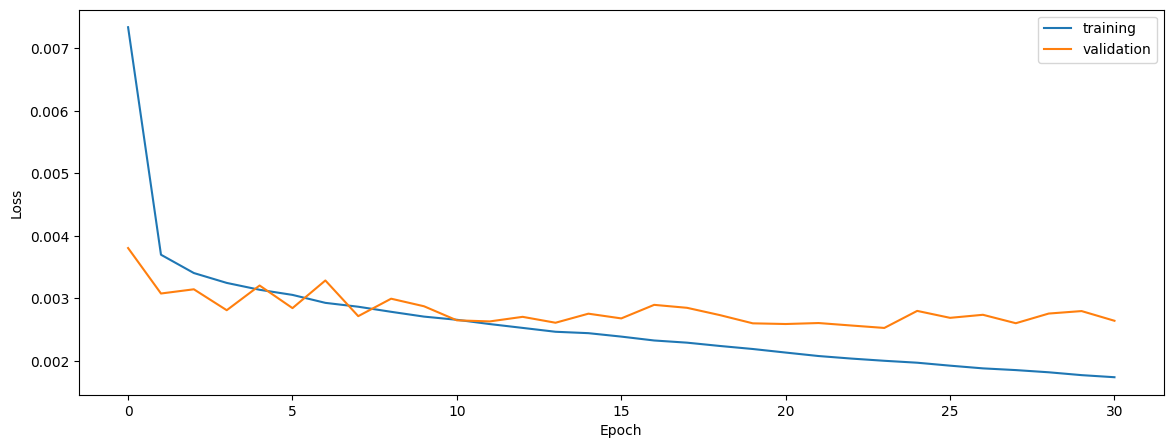

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8897405991656037
0.8478280682340756
0.8302322492697081


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8889439101079075
0.8604706438949684
0.8400393290395537


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8885249458886255
0.8595850511962856
0.8357497474729335


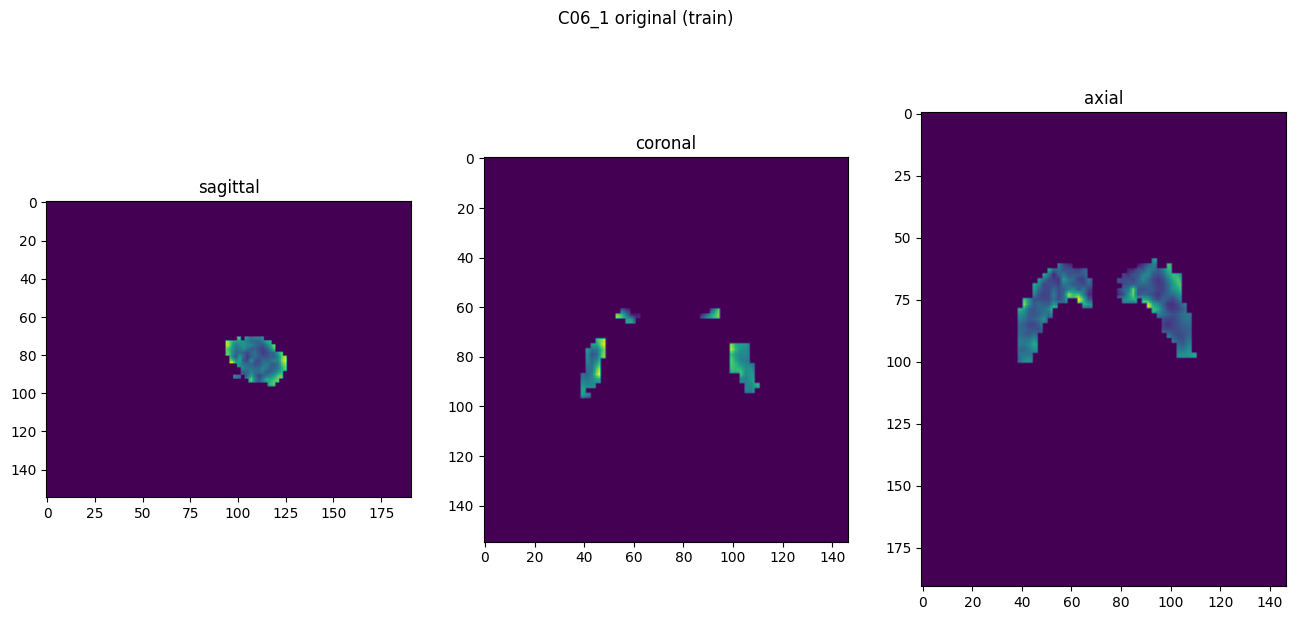

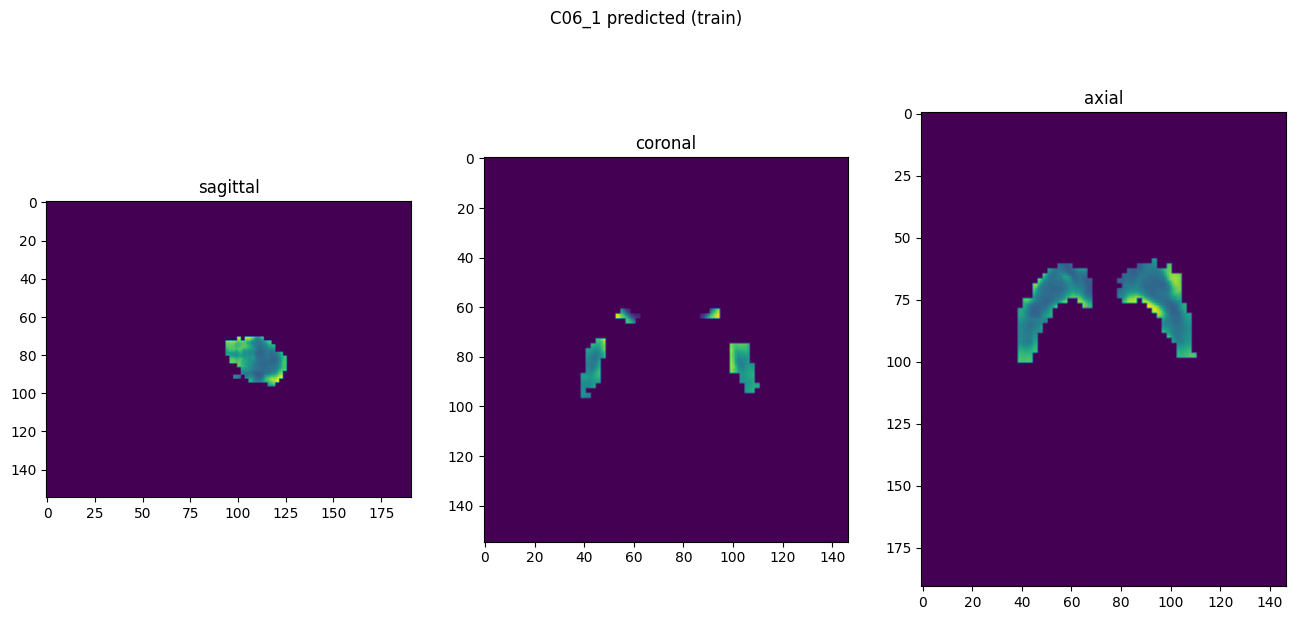

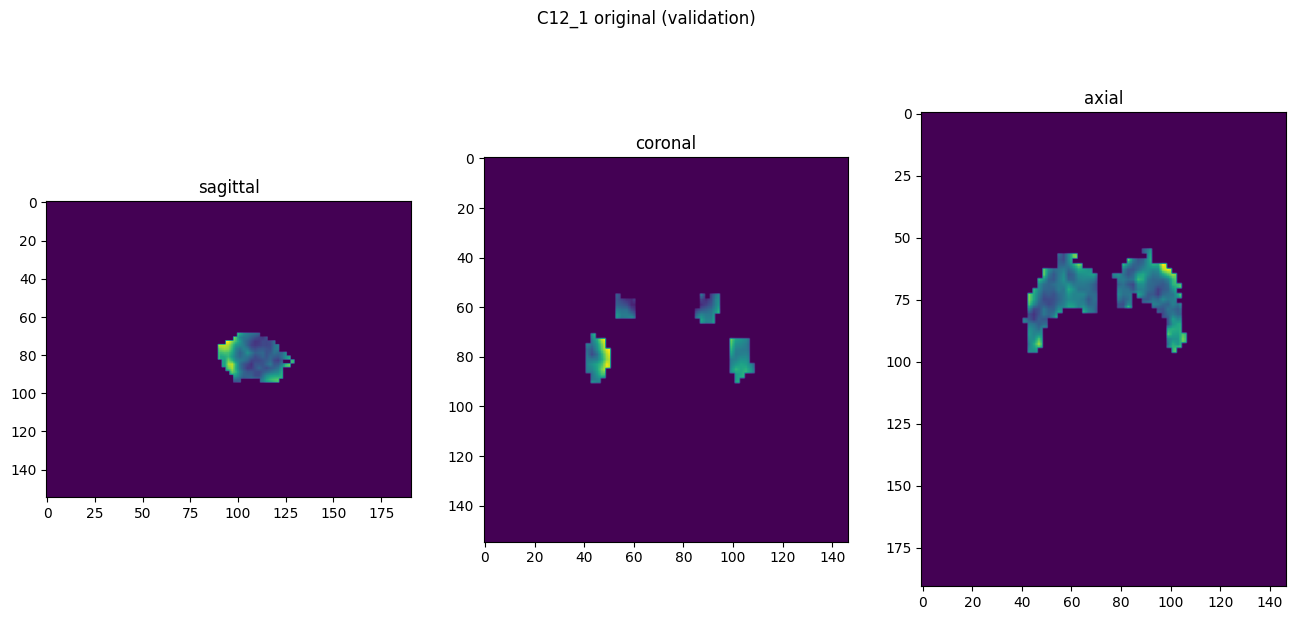

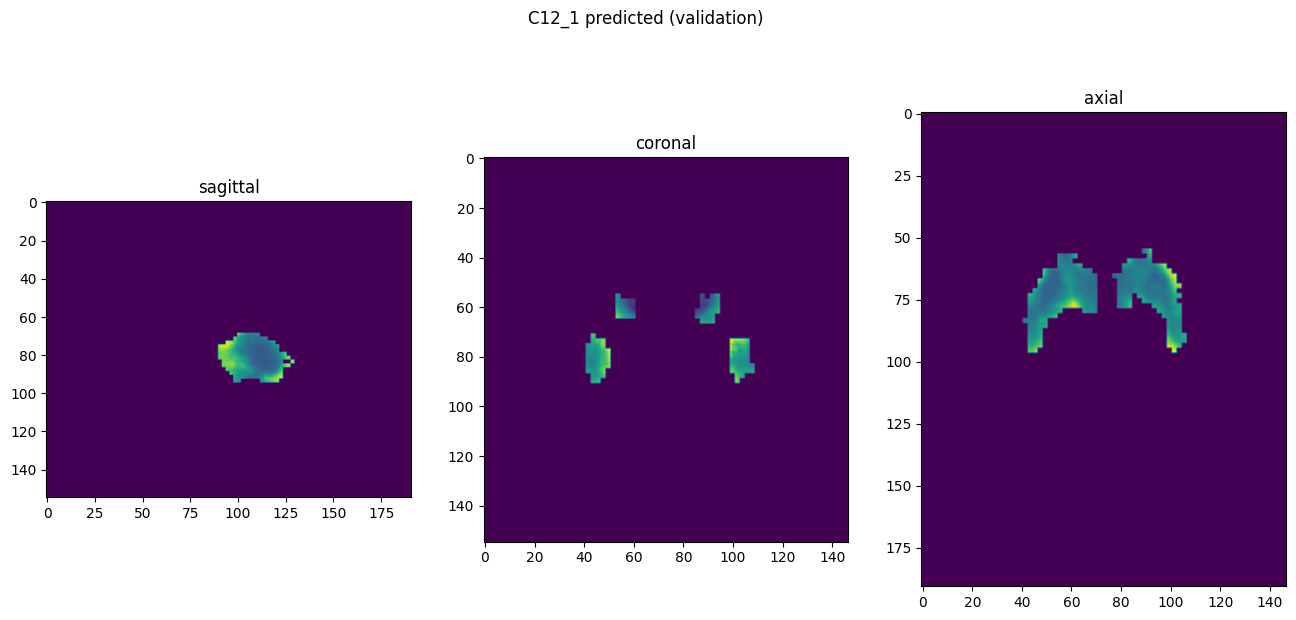

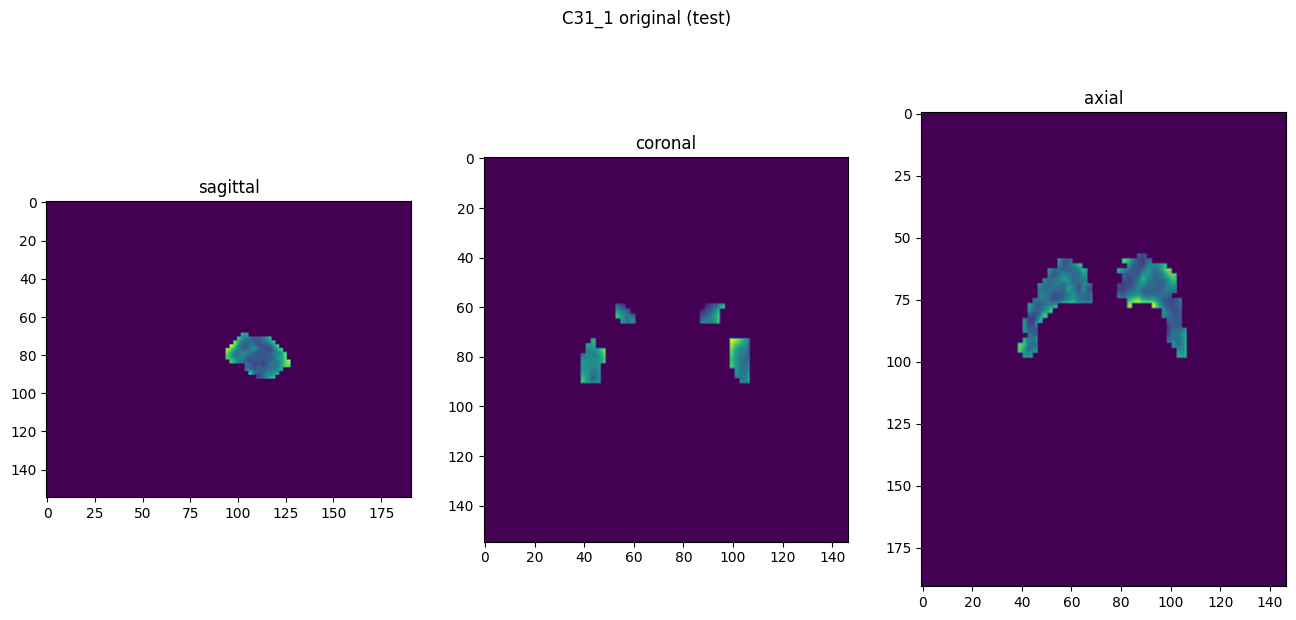

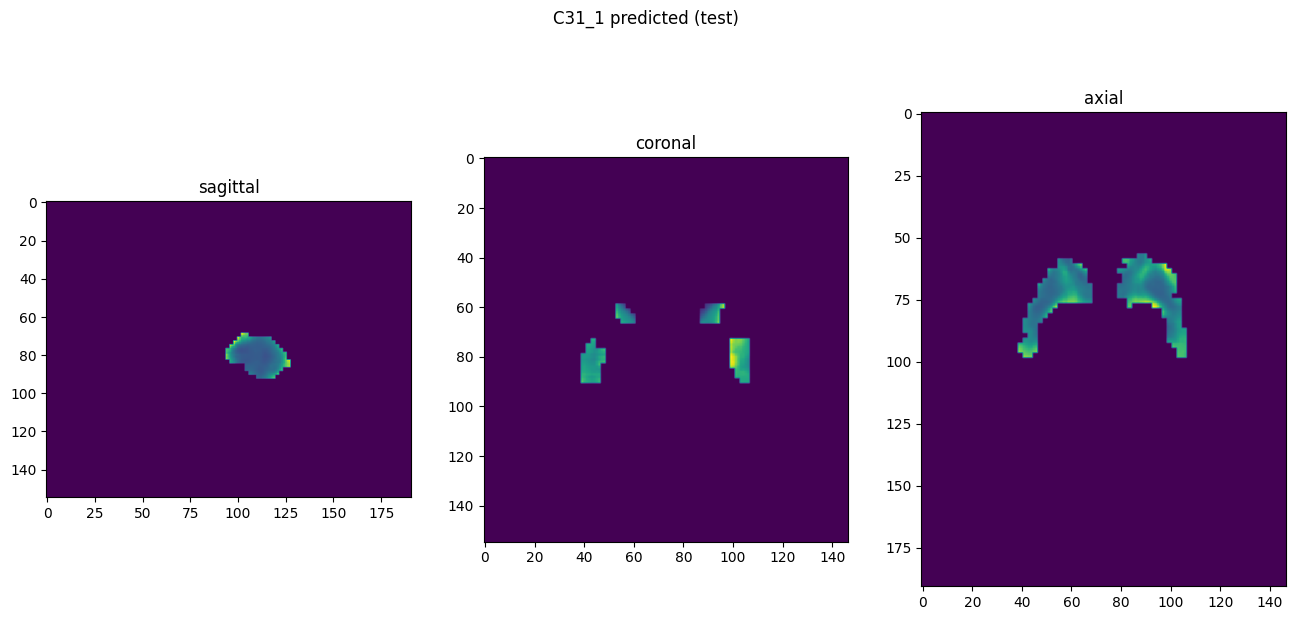

In [10]:
showResults(model, gen, threshold=None, background=False)